In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import os
import re
import sys
import glob
import time
import tarfile
from six.moves import urllib
import pickle

import argparse
import tempfile
import pandas as pd

import scipy
from scipy import special

from random import shuffle

from sklearn import ensemble as ens
from sklearn import metrics as met
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import matthews_corrcoef

import eto_utils as utils

# import xgboost as xgb
import lightgbm as lgb

import time
from datetime import datetime

from numpy import arange
from numpy import argmax

# from keras.datasets import imdb
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers.embeddings import Embedding
# from keras.preprocessing import sequence

import pickle

import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# check version number
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.under_sampling import TomekLinks
from sklearn.datasets import make_classification
print(imblearn.__version__)

0.10.1


In [3]:
def context_feat(pred,dog_id_column_list,c_left,c_right):
    cla = pred[0].size
    x_out = np.zeros((len(pred),(c_left+c_right+1)*cla)).astype(np.float32)
    valid = np.zeros(len(pred)).astype(np.int32)
    dogs = np.unique(dog_id_column_list)
    ids = np.array(range(len(pred)))
    if (c_left>0) & (c_right>0):        
        for i in dogs:
            act = ids[dog_id_column_list[:]==i][0]
            act_pred = pred[dog_id_column_list[:]==i]
            for k in range(c_left,len(act_pred)-c_right,1):
                x_out[act+k,:cla] = act_pred[k]
                x_out[act+k,cla:(1+c_left)*cla] = act_pred[(k-c_left):k].flatten()
                x_out[act+k,(1+c_left)*cla:] = act_pred[(k+1):k+c_right+1].flatten()
                valid[act+k]=1
#     else:
#         if (c_left==0) & (c_right>0):
#             for i in dogs:
#                 act = ids[dog_id_column_list[:]==i][0]
#                 act_pred = pred[dog_id_column_list[:]==i]
#                 for k in range(0,len(act_pred)-c_right,1):
#                     x_out[act+k,:cla] = act_pred[k]
#                     x_out[act+k,(1+c_left)*cla:] = act_pred[(k+1):k+c_right+1].flatten()
#                     valid[act+k]=1
#         if (c_left>0) & (c_right==0):
#             for i in dogs:
#                 act = ids[dog_id_column_list[:]==i][0]
#                 act_pred = pred[dog_id_column_list[:]==i]
#                 for k in range(c_left,len(act_pred)-1
#                                ,1):
#                     x_out[act+k,:cla] = act_pred[k]
#                     x_out[act+k,cla:(1+c_left)*cla] = act_pred[(k-c_left):k].flatten()
#                     valid[act+k]=1
#         if (c_left<1) & (c_right<1):
#             for i in dogs:
#                 act = ids[dog_id_column_list[:]==i][0]
#                 act_pred = pred[dog_id_column_list[:]==i]
#                 for k in range(0,len(act_pred)-1,1):
#                     x_out[act+k,:cla] = act_pred[k]
    return x_out,valid 

In [4]:
# INPUT
# base labels and dogs
fname_labels = "labels_2022_apr_01.dms"
fname_dogs = "dogs_2018_dec_28.dms"

# data files input 
path = "/Volumes/Gabor_SSD/ML/gabor_venv_tensor/jupyterNotebook/SensDog_Bout_article_Royal_Society_Open_Science/Data/Sztaki_Balint_filtered_56_list/"
path_base = "/Volumes/WD_Black_2TB/SensDog_Bout_Article_POS_Computing/"


# OUTPUT
# Features and models results
path_results = path_base + "Results/"
path_models = path_base + "Models/"
path_figures = path_base + "Figures/"

# converted base data files for features
fname_ts_base = path_results + "Sensdog_2022_jun26_ts_lgb_threshold_SMOTE_behav_base.csv"
fname_ts_final = path_results + "Sensdog_2022_jun26_ts_lgb_threshold_SMOTE_behav_final.csv"
fname_ts_base_filt = path_results + "Sensdog_2022_jun26_ts_lgb_threshold_SMOTE_base_result_filt.csv"

# ML results
fname_results_raw = path_results + "apr01_2022_results_raw_sensdog_LGBM_Threshold_SMOTE_1.csv"
fname_results_all = path_results + "apr01_2022_results_all_sensdog_LGBM_Threshold_SMOTE_1.csv"

In [5]:
extension = 'csv'
os.chdir(path)
filenames = [i for i in glob.glob('*.{}'.format(extension))]
os.chdir("..")
conv=""

num=0
dog_names = []
dfs = []

for fn in filenames:
    fn = str(fn).split('.')[0]
#     print("-> %s" %(fn))
    # dfs.append(utils.convert_to_ts_bout(fn,path,conv))
    dfs.append(utils.convert_to_ts(fn,path,conv))
    num+=1
    dog_names.append(fn)
    print("finished: %s -> %d" %(fn,len(dfs[num-1])))

finished: Pepe_SensDog_Mixed_2016-09-21-09-06-59 -> 99600
finished: Flodni_Sensdog_Mixed_2016-08-04-15-10-09 -> 30600
finished: Arnika_Sensdog_Mudi_2016-09-21-13-03-21 -> 34800
finished: Marcipán_SensDog_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2016-09-21-17-37-47 -> 42300
finished: Csaba_SensDog_Mudi_2016-08-30-15-54-06 -> 35700
finished: Oszkár_Experiment_name_Mixed_2016-09-08-09-57-33 -> 48300
finished: Nándi_Signtr2_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-03-13-09-10-36 -> 30000
finished: Józsi_Experiment_name_Havanese_2016-08-01-15-58-49 -> 18300
finished: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42 -> 78000
finished: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58 -> 87000
finished: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19 -> 32100
finished: Guba_Guba_september_Mudi_2016-09-06-16-58-16 -> 88200
finished: Gino_Experiment_name_EnglishCockerSpaniel_2016-08-01-12-10-47 -> 17100
finished: Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-0

In [6]:
df_all = dfs[0]

for k in range(0,len(dfs),1):
    df_all=df_all.append(other=dfs[k],ignore_index=True)
    print("%d %s ---> %d " %(k,str(dog_names[k]),len(dfs[k])))
print("Total ---> %d" %(len(df_all)))

0 Pepe_SensDog_Mixed_2016-09-21-09-06-59 ---> 99600 
1 Flodni_Sensdog_Mixed_2016-08-04-15-10-09 ---> 30600 
2 Arnika_Sensdog_Mudi_2016-09-21-13-03-21 ---> 34800 


/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/2451538691.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all=df_all.append(other=dfs[k],ignore_index=True)


3 Marcipán_SensDog_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2016-09-21-17-37-47 ---> 42300 
4 Csaba_SensDog_Mudi_2016-08-30-15-54-06 ---> 35700 
5 Oszkár_Experiment_name_Mixed_2016-09-08-09-57-33 ---> 48300 
6 Nándi_Signtr2_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-03-13-09-10-36 ---> 30000 
7 Józsi_Experiment_name_Havanese_2016-08-01-15-58-49 ---> 18300 
8 Mano_Sensdogneck_Mixed_2017-05-11-12-37-42 ---> 78000 
9 Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58 ---> 87000 
10 Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19 ---> 32100 
11 Guba_Guba_september_Mudi_2016-09-06-16-58-16 ---> 88200 
12 Gino_Experiment_name_EnglishCockerSpaniel_2016-08-01-12-10-47 ---> 17100 
13 Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12 ---> 96000 
14 Szamóca_SensDog_Whippet_2016-09-22-10-25-32 ---> 94800 
15 Sofi_Sensdogneck_Mixed_2017-04-12-17-58-35 ---> 57000 
16 Demona_SensDog_short_AustralianShepherd_2017-04-08-10-49-05 ---> 12000 
17 Toby_SensDog_short_

In [7]:
df_all.head()

,name,timestamp,label,attitude_1,attitude_2,attitude_3,attitude_4,gravity_x,gravity_y,gravity_z,rotation_rate_x,rotation_rate_y,rotation_rate_z,user_acceleration_x,user_acceleration_y,user_acceleration_z
0,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.650,NaN,-0.646825134754181,-0.727397859096527,-0.008848536759615,0.228978171944618,-9.188303582122922,-3.379012323206664,0.572432625300996,-0.306010544300079,0.518639266490936,-0.023100087419152,6.283460676527023,3.005431231765449,-9.528093755382299
1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.662,NaN,-0.650136291980743,-0.723871886730194,-0.008320278488100,0.230787679553032,-9.192658854722977,-3.382706501549483,0.471890805154294,-0.294038057327271,0.388468235731125,-0.000290378928185,6.027465807807445,2.989743833290040,-9.223273188695311
2,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.680,NaN,-0.651694953441620,-0.721738874912262,-0.006250622682273,0.233124718070030,-9.196606131044030,-3.379933821965754,0.410821638620272,-0.421182274818420,0.102612517774105,0.053435429930687,5.721593101719021,3.241660492785275,-9.207392313474417
3,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.701,NaN,-0.652058899402618,-0.720573008060455,-0.002555690240115,0.235768035054207,-9.203609287804365,-3.364750573620201,0.377202825602330,-0.479395240545273,-0.011876771226525,0.135212048888206,5.770045874720812,3.278889860983194,-9.417765248703956
4,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.721,NaN,-0.652446210384369,-0.719737648963928,-0.000214312050957,0.237257644534111,-9.209214268204569,-3.351973509633541,0.353477337828279,-0.034247558563948,0.027018696069717,0.052976302802563,5.751753846704959,3.281612563945354,-9.629129533058405


In [8]:
df_all.to_csv(fname_ts_base)

In [9]:
labels,label_dict,dog_id_column_list,dog_dict = utils.make_labels_dogids(df_all,labels_dict_fname=fname_labels,dog_names=dog_names)
df_all['dog_id'] = dog_id_column_list
df_all['label_id'] = labels
# df_all.head()
cols = df_all.columns.tolist()
cols = cols[-1:] + cols[:-1]
cols = cols[-1:] + cols[:-1]
df_all = df_all[cols]

[0 0 0 ... 0 0 0]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
{'Pepe_SensDog_Mixed_2016-09-21-09-06-59': 0, 'Flodni_Sensdog_Mixed_2016-08-04-15-10-09': 1, 'Arnika_Sensdog_Mudi_2016-09-21-13-03-21': 2, 'Marcipán_SensDog_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2016-09-21-17-37-47': 3, 'Csaba_SensDog_Mudi_2016-08-30-15-54-06': 4, 'Oszkár_Experiment_name_Mixed_2016-09-08-09-57-33': 5, 'Nándi_Signtr2_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-03-13-09-10-36': 6, 'Józsi_Experiment_name_Havanese_2016-08-01-15-58-49': 7, 'Mano_Sensdogneck_Mixed_2017-05-11-12-37-42': 8, 'Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58': 9, 'Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19': 10, 'Guba_Guba_september_Mudi_2016-09-06-16-58-16': 11, 'Gino_Experiment_name_EnglishCockerSpaniel_2016-08-01-12-10-47': 12, 'Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12': 13, 'Szamóca_SensDog_Whippet_2016-09-22-10-25-32': 14, 'Sofi_Sensdogneck_Mixed_2017-04-12-17-58-35': 15, 'Demona_Sens

In [10]:
df_all = utils.clearNaN(df_all)
df_all.to_csv(fname_ts_final)
df_all

,dog_id,label_id,name,timestamp,label,attitude_1,attitude_2,attitude_3,attitude_4,gravity_x,gravity_y,gravity_z,rotation_rate_x,rotation_rate_y,rotation_rate_z,user_acceleration_x,user_acceleration_y,user_acceleration_z
0,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.650,unknown,-0.646825134754181,-0.727397859096527,-0.008848536759615,0.228978171944618,-9.188303582122922,-3.379012323206664,0.572432625300996,-0.306010544300079,0.518639266490936,-0.023100087419152,6.283460676527023,3.005431231765449,-9.528093755382299
1,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.662,unknown,-0.650136291980743,-0.723871886730194,-0.008320278488100,0.230787679553032,-9.192658854722977,-3.382706501549483,0.471890805154294,-0.294038057327271,0.388468235731125,-0.000290378928185,6.027465807807445,2.989743833290040,-9.223273188695311
2,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.680,unknown,-0.651694953441620,-0.721738874912262,-0.006250622682273,0.233124718070030,-9.196606131044030,-3.379933821965754,0.410821638620272,-0.421182274818420,0.102612517774105,0.053435429930687,5.721593101719021,3.241660492785275,-9.207392313474417
3,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.701,unknown,-0.652058899402618,-0.720573008060455,-0.002555690240115,0.235768035054207,-9.203609287804365,-3.364750573620201,0.377202825602330,-0.479395240545273,-0.011876771226525,0.135212048888206,5.770045874720812,3.278889860983194,-9.417765248703956
4,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1474441619.721,unknown,-0.652446210384369,-0.719737648963928,-0.000214312050957,0.237257644534111,-9.209214268204569,-3.351973509633541,0.353477337828279,-0.034247558563948,0.027018696069717,0.052976302802563,5.751753846704959,3.281612563945354,-9.629129533058405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767495,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1477235115.194,lay,0.466703087091446,-0.039172973483801,-0.217133805155754,-0.856449782848358,-2.645573252989351,-3.288798383796215,-8.851842845547198,-0.009053095243871,0.041952077299356,-0.040951978415251,0.041688685694337,0.607576894320548,-0.120142044684291
2767496,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1477235115.213,lay,0.466546148061752,-0.038659010082483,-0.216718479990959,-0.856663823127747,-2.632633399656415,-3.287555105736852,-8.856161877790093,-0.013813229277730,0.069593980908394,-0.014152055606246,0.280710353911668,0.389246570345759,-0.213795310893655
2767497,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1477235115.233,lay,0.466945976018906,-0.038372509181499,-0.216545030474663,-0.856502771377563,-2.627809340500832,-3.286277633146942,-8.858068588194250,0.016734825447202,0.010763265192509,0.060224443674088,0.298471636051685,0.338213133201003,-0.374045494082570
2767498,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1477235115.252,lay,0.467181950807571,-0.038819968700409,-0.217005893588066,-0.856237232685089,-2.640349088600278,-3.288611629052460,-8.853471908053756,0.030027728527784,-0.071873784065247,0.025913072749972,0.038068449370563,0.524228749026358,-0.327493586266041


In [11]:
data_filt,labels,cat_inv,dog_fold,dog_occ,dog_inv,dog_fold_inv = utils.get_raw_ts(fname_labels=fname_labels,fname_data=fname_ts_final)

In [12]:
data_filt
data_filt.to_csv(fname_ts_base_filt)

In [5]:
ts_raw = pd.read_csv(fname_ts_final,sep=",")

In [6]:
ts_raw

,Unnamed: 0,dog_id,label_id,name,timestamp,label,attitude_1,attitude_2,attitude_3,attitude_4,gravity_x,gravity_y,gravity_z,rotation_rate_x,rotation_rate_y,rotation_rate_z,user_acceleration_x,user_acceleration_y,user_acceleration_z
0,0,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.646825,-0.727398,-0.008849,0.228978,-9.188304,-3.379012,0.572433,-0.306011,0.518639,-0.023100,6.283461,3.005431,-9.528094
1,1,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.650136,-0.723872,-0.008320,0.230788,-9.192659,-3.382707,0.471891,-0.294038,0.388468,-0.000290,6.027466,2.989744,-9.223273
2,2,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.651695,-0.721739,-0.006251,0.233125,-9.196606,-3.379934,0.410822,-0.421182,0.102613,0.053435,5.721593,3.241660,-9.207392
3,3,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.652059,-0.720573,-0.002556,0.235768,-9.203609,-3.364751,0.377203,-0.479395,-0.011877,0.135212,5.770046,3.278890,-9.417765
4,4,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.652446,-0.719738,-0.000214,0.237258,-9.209214,-3.351974,0.353477,-0.034248,0.027019,0.052976,5.751754,3.281613,-9.629130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767495,2767495,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lay,0.466703,-0.039173,-0.217134,-0.856450,-2.645573,-3.288798,-8.851843,-0.009053,0.041952,-0.040952,0.041689,0.607577,-0.120142
2767496,2767496,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lay,0.466546,-0.038659,-0.216718,-0.856664,-2.632633,-3.287555,-8.856162,-0.013813,0.069594,-0.014152,0.280710,0.389247,-0.213795
2767497,2767497,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lay,0.466946,-0.038373,-0.216545,-0.856503,-2.627809,-3.286278,-8.858069,0.016735,0.010763,0.060224,0.298472,0.338213,-0.374045
2767498,2767498,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lay,0.467182,-0.038820,-0.217006,-0.856237,-2.640349,-3.288612,-8.853472,0.030028,-0.071874,0.025913,0.038068,0.524229,-0.327494


In [17]:
ts_raw = ts_raw.replace({'lay': 'lie'}, regex=True)

In [18]:
ts_raw

,Unnamed: 0,dog_id,label_id,name,timestamp,label,attitude_1,attitude_2,attitude_3,attitude_4,gravity_x,gravity_y,gravity_z,rotation_rate_x,rotation_rate_y,rotation_rate_z,user_acceleration_x,user_acceleration_y,user_acceleration_z
0,0,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.646825,-0.727398,-0.008849,0.228978,-9.188304,-3.379012,0.572433,-0.306011,0.518639,-0.023100,6.283461,3.005431,-9.528094
1,1,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.650136,-0.723872,-0.008320,0.230788,-9.192659,-3.382707,0.471891,-0.294038,0.388468,-0.000290,6.027466,2.989744,-9.223273
2,2,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.651695,-0.721739,-0.006251,0.233125,-9.196606,-3.379934,0.410822,-0.421182,0.102613,0.053435,5.721593,3.241660,-9.207392
3,3,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.652059,-0.720573,-0.002556,0.235768,-9.203609,-3.364751,0.377203,-0.479395,-0.011877,0.135212,5.770046,3.278890,-9.417765
4,4,0,-1,Pepe_SensDog_Mixed_2016-09-21-09-06-59,1.474442e+09,unknown,-0.652446,-0.719738,-0.000214,0.237258,-9.209214,-3.351974,0.353477,-0.034248,0.027019,0.052976,5.751754,3.281613,-9.629130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767495,2767495,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lie,0.466703,-0.039173,-0.217134,-0.856450,-2.645573,-3.288798,-8.851843,-0.009053,0.041952,-0.040952,0.041689,0.607577,-0.120142
2767496,2767496,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lie,0.466546,-0.038659,-0.216718,-0.856664,-2.632633,-3.287555,-8.856162,-0.013813,0.069594,-0.014152,0.280710,0.389247,-0.213795
2767497,2767497,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lie,0.466946,-0.038373,-0.216545,-0.856503,-2.627809,-3.286278,-8.858069,0.016735,0.010763,0.060224,0.298472,0.338213,-0.374045
2767498,2767498,55,4,Tasli_SensDog_1_Mixed_2016-10-23-16-16-30,1.477235e+09,lie,0.467182,-0.038820,-0.217006,-0.856237,-2.640349,-3.288612,-8.853472,0.030028,-0.071874,0.025913,0.038068,0.524229,-0.327494


# FEATURES

# Bout length

In [22]:
# behaviour elements' labels
labels = ts_raw['label_id'].values.astype(np.int32)
dogs = ts_raw['name'].values
label_names_sequence = ts_raw['label'].values
list_labels = np.unique(labels)

stat_labels = []
labels_inv = {}

for k in range(len(list_labels)):
    stat_labels.append([])
    labels_inv[list_labels[k]]=k

In [27]:
list_labels

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 20, 23, 26, 27, 30, 31,
       32, 33], dtype=int32)

In [9]:
# behaviour elements' bout-lengths collection
# last = labels[0]
# n = 0
# for k in range(len(labels)):

#     act = labels[k]
#     # print(k, last)
#     # print("%dth -> %d and %s (%d)" %(k, act,label_names_sequence[k],last),end=" ") #,stat_labels[labels_inv[last]])
#     if act == last:
#         n += 1
#     else:
#         if n > 0:
#             stat_labels[labels_inv[last]].append(n)
#             # print("dog: %s done: %d cat %s"% (dogs[k],last,stat_labels[labels_inv[last]]))
#             # if n == 1:
#             #     raise SystemExit("Stop right here!")
#             n = 0


#     last = act
#     # if k > 10000:
#     #     raise SystemExit("Stop right there!")
# label_names = pd.read_csv(fname_labels,sep=" ")
# for x in range(len(list_labels)):
#     print(label_names[label_names['label_id']==list_labels[x]].values)

In [28]:
# behaviour elements' bout-lengths collection
last = labels[0]
n = 0
filter_index = 0
for k in range(len(labels)):

    act = labels[k]
    # print(k, last)
    # print("%dth -> %d and %s (%d)" %(k, act,label_names_sequence[k],last),end=" ") #,stat_labels[labels_inv[last]])
    if act == last:
        n += 1
        if filter_index > 0:
            n = n + filter_index
            filter_index = 0
    else:
        filter_index += 1
        if n > 1:
            stat_labels[labels_inv[last]].append(n)
            # print("dog: %s done: %d cat %s"% (dogs[k],last,stat_labels[labels_inv[last]]))
            # if n == 1:
            #     raise SystemExit("Stop right here!")
            n = 0 + filter_index
            filter_index = 0
    if filter_index == 0:
        last = act
    # if k > 10000:
    #     raise SystemExit("Stop right there!")
label_names = pd.read_csv(fname_labels,sep=" ")
label_names = label_names.replace({'lay': 'lie'}, regex=True)
for x in range(len(list_labels)):
    print(label_names[label_names['label_id']==list_labels[x]].values)

[]
[[1 'spin']]
[[2 'stand']]
[[3 'sit']]
[[4 'lie']]
[[5 'walk']]
[[6 'trot']]
[[7 'run']]
[[8 'prance']]
[[9 'jump']]
[[10 'hop']]
[[20 'pliebow']]
[[23 'back']]
[[26 'eat']]
[[27 'drink']]
[[30 'bodyshake']]
[[31 'scratch']]
[[32 'chew']]
[[33 'turn']]


In [29]:
print('               Label name','            Median','           Mean',' Minimum','Maximum','   Std','   Count')
for k in range(len(stat_labels)):
    #plt.figure(figsize=(20,10))
    if list_labels[k]==-1:
        print('%25s' % "na",'%10s' % "med: ",'%6s' % np.median(stat_labels[k]),'%10s' % "mean: ",'%6s' % round(np.mean(stat_labels[k]),2),'%6s' % np.min(stat_labels[k]),'%6s' % np.max(stat_labels[k]),'%10s' % round(np.std(stat_labels[k]),2),'%6s' % np.count_nonzero(stat_labels[k])) #,bins=100,label=str(list_labels[k]),alpha=1)
    else:
        print('%25s' % label_names[label_names['label_id']==list_labels[k]].values,'%10s' % "med: ",'%6s' % np.median(stat_labels[k]),'%10s' % "mean: ",'%7s' % round(np.mean(stat_labels[k]),2),'%6s' % np.min(stat_labels[k]),'%6s' % np.max(stat_labels[k]),'%10s' % round(np.std(stat_labels[k]),2),'%6s' % np.count_nonzero(stat_labels[k])) #,bins=100,label=str(list_labels[k]),alpha=1)        
    #plt.legend()
    #plt.show()    #plt.legend()
    #plt.show()

               Label name             Median            Mean  Minimum Maximum    Std    Count
                       na      med:    41.0     mean:  176.89      2  77762    1745.79   6627
             [[1 'spin']]      med:    86.0     mean:    88.29      6    217      43.95    195
            [[2 'stand']]      med:    77.0     mean:   196.77      2  18882     596.16   8856
              [[3 'sit']]      med:   174.0     mean:   371.57      5  12805     800.78   1620
              [[4 'lie']]      med:   293.0     mean:    663.8      5  50019    2656.84   1182
             [[5 'walk']]      med:    62.0     mean:   169.71      2  24572      547.5  11796
             [[6 'trot']]      med:    84.5     mean:   130.04      3   1462     151.01   4218
              [[7 'run']]      med:    66.0     mean:    100.7      2   1595     116.53   3345
           [[8 'prance']]      med:    44.0     mean:    96.34      5    946     152.03    366
             [[9 'jump']]      med:    41.0     mean

In [30]:
from matplotlib.font_manager import fontManager, FontProperties

path = "/Users/gabor/Library/Fonts/Aller_Lt.ttf"
fontManager.addfont(path)

prop = FontProperties(fname=path)

In [20]:
print(label_names)
print(stat_labels[12])

    label_id      label
0          1       spin
1          2      stand
2          3        sit
3          4        lay
4          5       walk
5          6       trot
6          7        run
7          8     prance
8          9       jump
9         10        hop
10        20    playbow
11        23       back
12        24      stalk
13        26        eat
14        27      drink
15        30  bodyshake
16        31    scratch
17        32       chew
18        33       turn
[31, 61, 26, 108, 15, 46, 31, 61, 26, 108, 15, 46, 76, 87, 15, 92, 56, 117, 10, 27, 5, 26, 51, 31, 73, 30, 142, 51, 132, 102, 81, 81, 132, 82, 30, 61, 32, 54, 112, 153, 173, 39, 49, 51, 5, 36, 10, 41, 72, 41, 82, 61, 41, 61, 68, 46, 15, 98, 35, 21, 30, 25, 46, 31, 82, 51, 35, 103, 31, 51, 26, 61, 20, 61, 61, 81, 223, 143, 92, 20, 57, 51, 83, 16, 26, 46, 46, 10, 86, 36, 26, 31, 41, 76, 26, 36, 21, 31, 26, 31, 81, 20, 56, 26, 66, 61, 67, 26, 46, 36, 138, 31, 25, 62, 52, 128, 93, 72, 40, 31, 176, 14, 10, 3, 71, 77, 55

In [34]:
label_id = 26
label_name = label_names[label_names['label_id']==label_id]['label'].item()
full_bout_list = stat_labels[13]
bout_list = stat_labels[13]
bout_list = [item for item in bout_list if item < 800]
print(label_name)

eat


In [46]:
label_id = 7
label_name = label_names[label_names['label_id']==label_id]['label'].item()
full_bout_list = [item for item in stat_labels[label_id]]
bout_list = [item for item in stat_labels[label_id] if item < 800]
print(label_name)

run


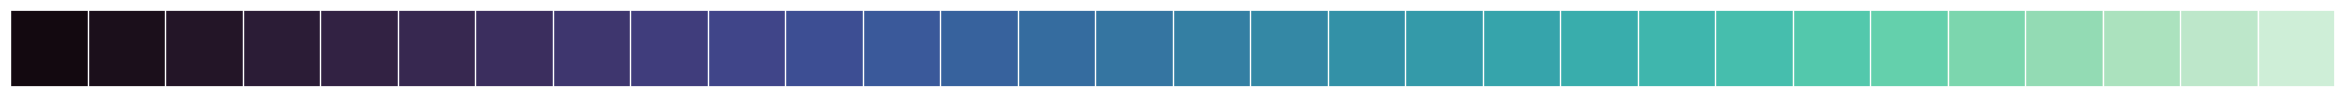

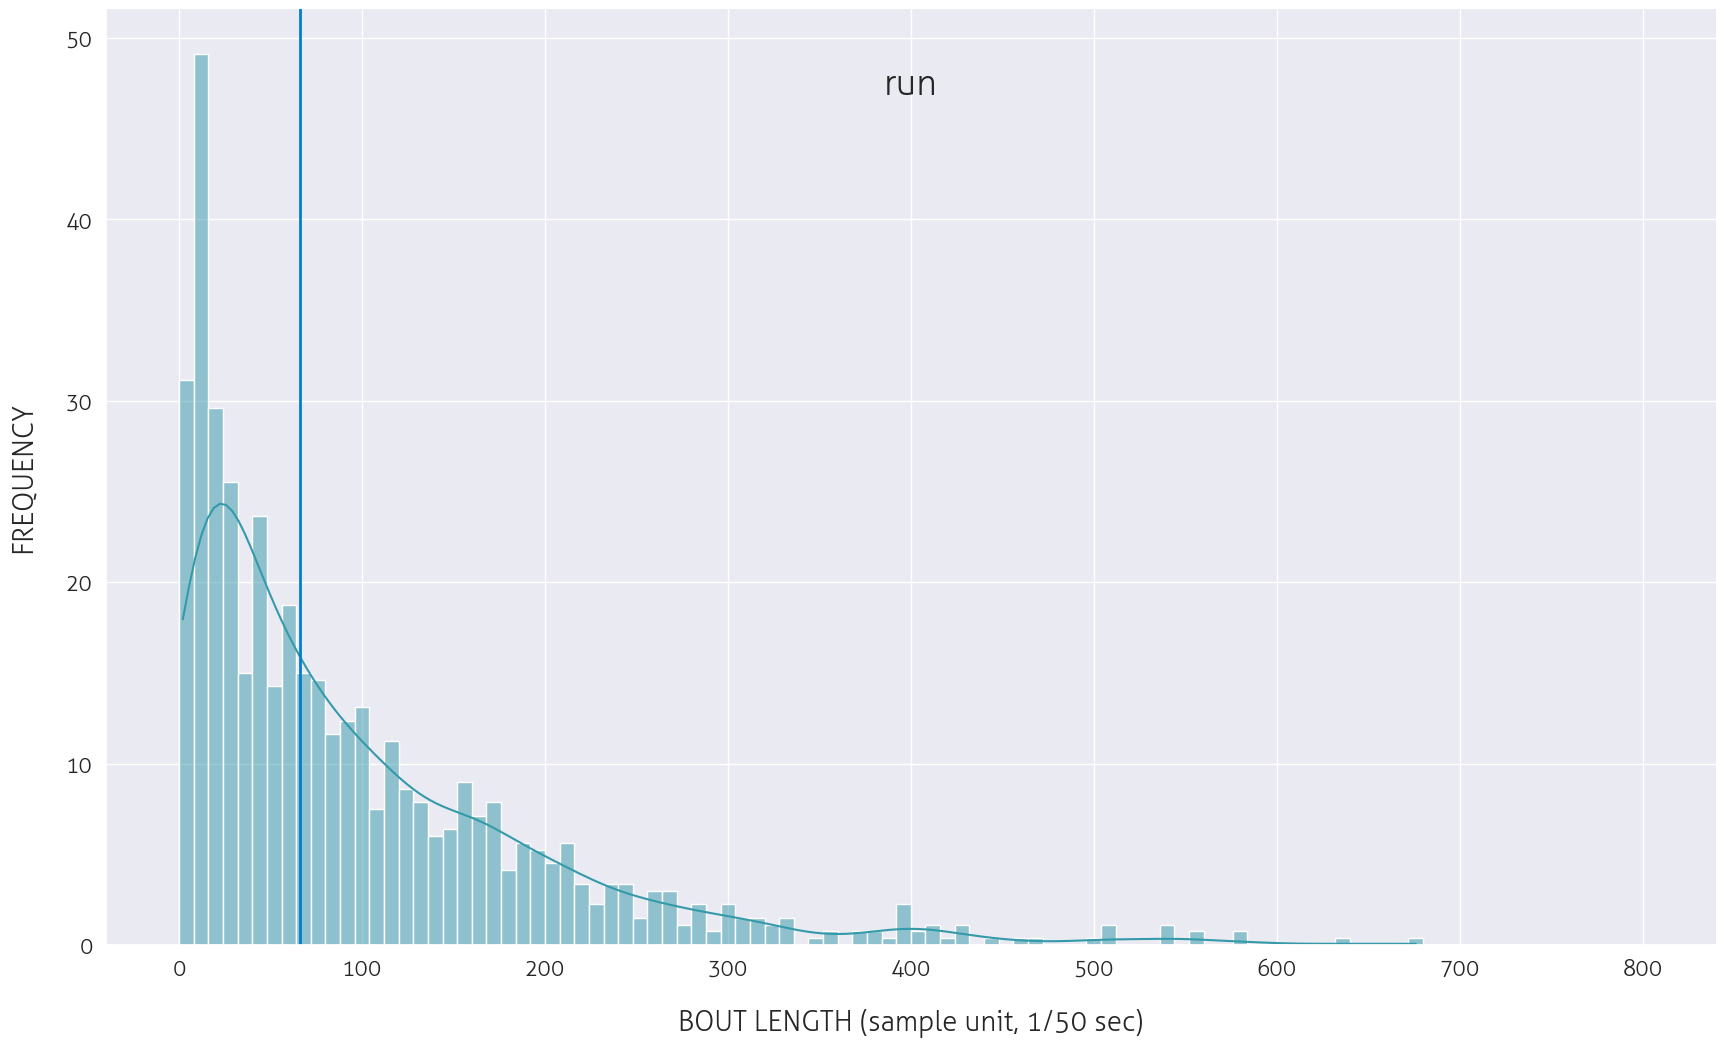

In [47]:
sns.set(style="whitegrid")
sns.set(font=prop.get_name())
# dist_palette = ["#a59c8b", "#a00000", "#003ba8", "#918BC3"]
# sns.set_palette(palette=dist_palette)
# chart = sns.displot(bout_list, kde=True,  bins=50, binrange=(0,500), height=10, aspect=15/10, stat="frequency", color="C3")
pal = sns.color_palette(sns.color_palette("mako",n_colors=30))
sns.palplot(pal)
# sns.set_style("ticks")
chart = sns.displot(bout_list, kde=True,  bins=100, binrange=(0,800), 
                    height=10, aspect=17/10, stat="frequency", color=pal[18])

# chart.set_title('Sample Title', fontdict={'size': 30})
# chart.fig.suptitle('\n Distribution of bout length',
#                   fontsize=28, y=1.08, fontdict={"weight": "bold"})
chart.ax.tick_params(labelsize=16)
plt.title(label_name, size=26, y=0.90)
chart.set_xlabels('BOUT LENGTH (sample unit, 1/50 sec)', fontdict={'size': 20},rotation=0, labelpad=20)
chart.set_ylabels('FREQUENCY', fontdict={'size': 20},rotation=90, labelpad=20)
plt.axvline(np.median(full_bout_list), linestyle='-', color = '#027ecc', linewidth = 2)
# plt.axvline(np.mean(full_bout_list),color=pal[25], linestyle='-')
chart.savefig(path_figures + "SensDog_bout_article_bout_freq_"+label_name, dpi=150)

##### np_bout_list = np.array(bout_list)
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
for ax in axes:
    sns.kdeplot(bout_list, fill=False, color='crimson', ax=ax).set(xlim=(0))
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    if ax == axes[0]:
        middle = np_bout_list.mean()
        sdev = np_bout_list.std()
        left = middle - sdev
        right = middle + sdev
        ax.set_title('Showing mean and sdev')
    else:
        left, middle, right = np.percentile(np_bout_list, [25, 50, 75])
        ax.set_title('Showing median and quartiles')
    ax.vlines(middle, 0, np.interp(middle, xs, ys), color='crimson', ls=':')
    mode_idx = np.argmax(ys)
    ax.vlines(xs[mode_idx], 0, ys[mode_idx], color='lime', ls='--')
    ax.fill_between(xs, 0, ys, facecolor='crimson', alpha=0.2)
    ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor='crimson', alpha=0.2)
    # ax.set_ylim(ymin=0)
plt.show()

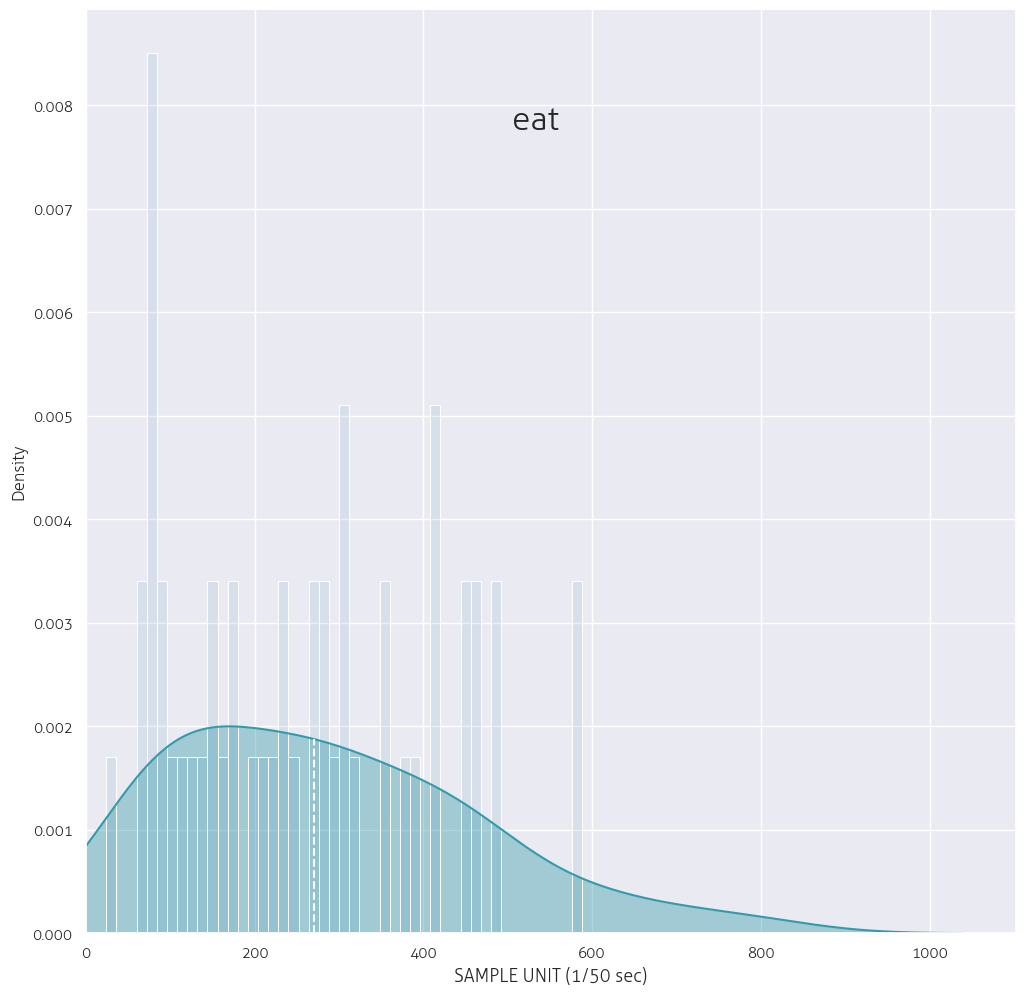

In [25]:
np_bout_list = np.array(bout_list)
fig, ax = plt.subplots(figsize=(12, 12))
sns.kdeplot(np_bout_list, fill=False, color=pal[18], ax=ax).set(xlim=(0))
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
ax.vlines(middle, 0, np.interp(middle, xs, ys), color="white", ls='--')
left, middle, right = np.percentile(np_bout_list, [25, 50, 75])
# ax.vlines(xs[mode_idx], 0, ys[mode_idx], color='crimson', ls='--')
ax.fill_between(xs, 0, ys, facecolor=pal[18], alpha=0.4)
# ax.fill_between(xs, 0, ys, where=(left <= xs) & (xs <= right), interpolate=True, facecolor=pal[18], alpha=0.2)
fig.suptitle(label_name,fontsize=24, y=0.8, fontdict={"weight": "bold"})
plt.xlabel('SAMPLE UNIT (1/50 sec)', fontdict={'size': 13})
sns.histplot(bout_list,  bins=50, binrange=(0,600), stat="density", color=pal[15], alpha=0.1, ax=ax)
fig.savefig(path_figures + "SensDog_bout_article_bout_freq_kde_"+label_name, dpi=600)

In [26]:
unique, counts = np.unique(bout_list, return_counts=True)
print(np.asarray((unique, counts)).T)

[[ 30   1]
 [ 66   2]
 [ 72   2]
 [ 73   1]
 [ 77   1]
 [ 82   1]
 [ 92   2]
 [107   1]
 [118   1]
 [123   1]
 [133   1]
 [153   1]
 [154   1]
 [163   1]
 [169   1]
 [179   1]
 [199   1]
 [210   1]
 [220   1]
 [230   1]
 [235   1]
 [240   1]
 [266   1]
 [275   1]
 [282   1]
 [286   1]
 [297   1]
 [300   1]
 [301   1]
 [310   1]
 [315   1]
 [351   1]
 [353   1]
 [379   1]
 [389   1]
 [414   2]
 [419   1]
 [445   1]
 [450   1]
 [460   1]
 [465   1]
 [480   2]
 [579   1]
 [587   1]
 [624   1]
 [711   1]
 [793   1]]


# Feature function

In [27]:
def stat_features_new(data_filt,cat_inv,dog_inv,str_t=100,cat_pol='last',window=32,shift=16,verbose=False):
    
    ndogs = data_filt['name'].value_counts().index
    
    print("actual window(act_w): %d shift: %d str_t: %d "%(window,shift,str_t))
    x_all = []
    y_all=[]
    x_t_all=[]
    #cat_hist = np.zeros((ndogs,len(cat_inv))).astype(np.int32)
    #cat_hist_all = []
    ts_str = []
    ts_end = []
    
    for i in range(len(ndogs)):
        data = data_filt[data_filt['name']==ndogs[i]]
        dogid = dog_inv[ndogs[i]]
        nstat_feat = 2*5
        nts = len(data.head(1).values[0,6:])
        dim = nstat_feat*nts
        ts_len = int((len(data)-window-str_t)/shift+1)

        if verbose==True:
            print("%dth dog samples: %d dimension: %d (data class: %d) name: %s"%(i,ts_len,dim,nts,ndogs[i]))
        
        c = dogid*np.ones((ts_len,1)).astype(np.int32)
        c_str = []
        y = np.zeros((ts_len,2)).astype(np.int32)
        x = np.zeros((ts_len,dim)).astype(np.float32)
        x_t = np.zeros((ts_len,2)).astype(np.int32)

        if cat_pol=='last':
            cat_idx = 0
        if cat_pol=='first':
            cat_idx = 1-window

        act_y = data['label_id'].values
        act_x = data.values[:,6:].astype(np.float32)
        ts_act = data['timestamp'].values
        act_grad_x = np.zeros((len(act_x),len(act_x[0,:])))
        act_grad_x[1:] = act_x[1:] - act_x[:-1]
        #print("diff: %f %s and %s" %(np.linalg.norm(act_grad_x-act_x),act_x.shape,act_grad_x.shape))
        
        #cat_hist = np.zeros((ts_len,len(cat_inv)+1)).astype(np.int32)

        for k in range(ts_len):
            str_x = k*shift+str_t
            act = act_x[str_x-window:str_x]
            act_grad = act_grad_x[str_x-window:str_x]
            act_sss = np.unique(act_y[str_x-window:str_x],return_counts=True)
            y[k,0] = act_y[str_x] 
            y[k,1] = act_sss[0][np.argsort(-act_sss[1])[0]] #int(cat_inv[act_y[str_x+cat_idx]])
            x_t[k,0] = ts_act[str_x-window:str_x][0]
            x_t[k,1] = ts_act[str_x-window:str_x][-1]
            
            #print("\tact diff:  %f %s vs %s" %(np.linalg.norm(act_grad-act),act.shape,act_grad.shape))
            
            #for l in range(window):
            #    act_sss = np.unique(act_y,return_counts=True)
            #    act_cat = act_sss[0][np.argsort(-act_sss[1])[0]]
            #    cat_hist[k,act_cat]+=1
            x[k,:nts] = np.min(act,axis=0)
            x[k,nts:2*nts] = np.max(act,axis=0)
            x[k,2*nts:3*nts] = np.mean(act,axis=0)
            x[k,3*nts:4*nts] = np.std(act,axis=0)
            x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)
            x[k,5*nts:6*nts] = np.min(act_grad,axis=0)
            x[k,6*nts:7*nts] = np.max(act_grad,axis=0)
            x[k,7*nts:8*nts] = np.mean(act_grad,axis=0)
            x[k,8*nts:9*nts] = np.std(act_grad,axis=0)
            x[k,9*nts:10*nts] = scipy.stats.skew(act_grad,axis=0)
            #print("\t %dth dog %dth td diff mean: %f" % (i,k,np.linalg.norm(x[k,7*nts:8*nts]-x[k,2*nts:3*nts])))
            #print("\t\tafter diff: %f %s and %s" %(np.linalg.norm(act_grad_x-act_x),act_x.shape,act_grad_x.shape))
        x_all.append(np.concatenate((x_t,c,y,x),axis=1))
        
        #cat_hist_all.append(cat_hist)
    full = x_all[0]
    for k in range(len(x_all)-1):
        full = np.concatenate((full,x_all[k+1]),axis=0).astype(np.float32)
    full = np.nan_to_num(np.array(full).astype(np.float32))
    return full#,cat_hist_all

# Feature calculation

In [28]:
act_window_list = [15, 32, 60, 81, 120, 149, 200, 300, 400, 500]
length_cat_count = len(act_window_list)

In [29]:
# feats = []
# shift_1 = 0

# for k in range(length_cat_count): #len(stat_labels)):
#     #act_window = min(np.median(stat_labels[k]),149)
#     act_window = act_window_list[k]
#     if act_window>= act_window_list[-1]:
#         act_window= act_window_list[-1]
#     if act_window <= 50:
#         shift_1 = 5
#     else:
#         shift_1 = int(act_window/10)
#     x_all = stat_features_new(data_filt,cat_inv,dog_inv,str_t=500,window=int(act_window),shift=shift_1,verbose=True)
#     feats.append(x_all)
#     np.savetxt(str(path_results+"feat_cat_"+str(k)),x_all)

actual window(act_w): 15 shift: 5 str_t: 500 
0th dog samples: 39738 dimension: 150 (data class: 15) name: Pepe_SensDog_Mixed_2016-09-21-09-06-59
1th dog samples: 30138 dimension: 150 (data class: 15) name: Fülöp_SensDog_Mixed_2016-09-23-09-13-17


/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


2th dog samples: 22098 dimension: 150 (data class: 15) name: Wayuu_Sensdogneck_Mixed_2017-05-16-11-27-26
3th dog samples: 19098 dimension: 150 (data class: 15) name: Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12
4th dog samples: 18858 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 18498 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 17538 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 17298 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 17178 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 16698 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 15498 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 15498 dimension: 150 (

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 7098 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 7038 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 6858 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 6858 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 6318 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 6318 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 6198 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 6018 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 6018 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 5898 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


2th dog samples: 22094 dimension: 150 (data class: 15) name: Wayuu_Sensdogneck_Mixed_2017-05-16-11-27-26
3th dog samples: 19094 dimension: 150 (data class: 15) name: Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12
4th dog samples: 18854 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 18494 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 17534 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 17294 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 17174 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 16694 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 15494 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 15494 dimension: 150 (

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 7094 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 7034 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 6854 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 6854 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 6314 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 6314 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 6194 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 6014 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 6014 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 5894 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


2th dog samples: 18407 dimension: 150 (data class: 15) name: Wayuu_Sensdogneck_Mixed_2017-05-16-11-27-26
3th dog samples: 15907 dimension: 150 (data class: 15) name: Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12
4th dog samples: 15707 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 15407 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 14607 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 14407 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 14307 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 13907 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 12907 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 12907 dimension: 150 (

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 5907 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 5857 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 5707 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 5707 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 5257 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 5257 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 5157 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 5007 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 5007 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 4907 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


2th dog samples: 13803 dimension: 150 (data class: 15) name: Wayuu_Sensdogneck_Mixed_2017-05-16-11-27-26
3th dog samples: 11928 dimension: 150 (data class: 15) name: Byron_Sensdogneck_GoldenRetriever_2017-05-15-13-04-12
4th dog samples: 11778 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 11553 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 10953 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 10803 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 10728 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 10428 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 9678 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 9678 dimension: 150 (da

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 4428 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 4390 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 4278 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 4278 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 3940 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 3940 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 3865 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 3753 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 3753 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 3678 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


4th dog samples: 7849 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 7699 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 7299 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 7199 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 7149 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 6949 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 6449 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 6449 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 6049 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog sample

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 2949 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 2924 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 2849 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 2849 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 2624 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 2624 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 2574 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 2499 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 2499 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 2449 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


4th dog samples: 6726 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 6597 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 6254 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 6168 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 6126 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 5954 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 5526 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 5526 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 5183 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog sample

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 2526 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 2504 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 2440 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 2440 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 2247 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 2247 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 2204 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 2140 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 2140 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 2097 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


4th dog samples: 4706 dimension: 150 (data class: 15) name: Szamóca_SensDog_Whippet_2016-09-22-10-25-32
5th dog samples: 4616 dimension: 150 (data class: 15) name: Fules_Sensdogneck_Mixed_2017-05-11-13-48-06
6th dog samples: 4376 dimension: 150 (data class: 15) name: Guba_Guba_september_Mudi_2016-09-06-16-58-16
7th dog samples: 4316 dimension: 150 (data class: 15) name: Luna_Sensdogneck_GoldenRetriever_2017-05-16-13-07-58
8th dog samples: 4286 dimension: 150 (data class: 15) name: Velúr_SensDog_Mixed_2016-09-21-18-46-37
9th dog samples: 4166 dimension: 150 (data class: 15) name: Nico_Sensdogneck_Mixed_2017-04-07-16-55-01
10th dog samples: 3866 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 3866 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 3626 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog sample

/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 1766 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 1751 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 1706 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 1706 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 1571 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 1571 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 1541 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 1496 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 1496 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 1466 dimension: 150 (data class: 15) name: Nándi

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


10th dog samples: 2574 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 2574 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 2414 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog samples: 2174 dimension: 150 (data class: 15) name: Sahara_Sensdogneck_Mixed_2017-04-07-14-29-26
14th dog samples: 1974 dimension: 150 (data class: 15) name: Rohan_Sensdogneck_BorderCollie_2017-04-11-17-12-37
15th dog samples: 1974 dimension: 150 (data class: 15) name: Sahara_Sensecollar_Mixed_2017-03-21-14-49-01
16th dog samples: 1954 dimension: 150 (data class: 15) name: Tasli_SensDog_1_Mixed_2016-10-23-16-16-30
17th dog samples: 1944 dimension: 150 (data class: 15) name: Málna_free_EnglishCockerSpaniel_2016-08-02-11-49-45
18th dog samples: 1874 dimension: 150 (data class: 15) name: Sofi_Sensdogneck_Mixed_2017-04-12-17-58-35


/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 1174 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 1164 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 1134 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 1134 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 1044 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 1044 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 1024 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 994 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 994 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 974 dimension: 150 (data class: 15) name: Nándi_Si

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


10th dog samples: 1928 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 1928 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 1808 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog samples: 1628 dimension: 150 (data class: 15) name: Sahara_Sensdogneck_Mixed_2017-04-07-14-29-26
14th dog samples: 1478 dimension: 150 (data class: 15) name: Rohan_Sensdogneck_BorderCollie_2017-04-11-17-12-37
15th dog samples: 1478 dimension: 150 (data class: 15) name: Sahara_Sensecollar_Mixed_2017-03-21-14-49-01
16th dog samples: 1463 dimension: 150 (data class: 15) name: Tasli_SensDog_1_Mixed_2016-10-23-16-16-30
17th dog samples: 1456 dimension: 150 (data class: 15) name: Málna_free_EnglishCockerSpaniel_2016-08-02-11-49-45
18th dog samples: 1403 dimension: 150 (data class: 15) name: Sofi_Sensdogneck_Mixed_2017-04-12-17-58-35


/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 878 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 871 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 848 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 848 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 781 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 781 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 766 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 743 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 743 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 728 dimension: 150 (data class: 15) name: Nándi_Signtr2_H

/var/folders/bz/6w0_xvb96fs9l9g82rgxvcqm0000gp/T/ipykernel_35525/1234492134.py:65: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  x[k,4*nts:5*nts] = scipy.stats.skew(act,axis=0)


10th dog samples: 1541 dimension: 150 (data class: 15) name: Mano_Sensdogneck_Mixed_2017-05-11-12-37-42
11th dog samples: 1541 dimension: 150 (data class: 15) name: Kiwi_Sensdogneck_HungarianShort-hairedPointingDog(Vizsla,short-haired)_2017-07-01-15-15-23
12th dog samples: 1445 dimension: 150 (data class: 15) name: Liza_SensDog_Mixed_2016-09-21-08-02-52
13th dog samples: 1301 dimension: 150 (data class: 15) name: Sahara_Sensdogneck_Mixed_2017-04-07-14-29-26
14th dog samples: 1181 dimension: 150 (data class: 15) name: Rohan_Sensdogneck_BorderCollie_2017-04-11-17-12-37
15th dog samples: 1181 dimension: 150 (data class: 15) name: Sahara_Sensecollar_Mixed_2017-03-21-14-49-01
16th dog samples: 1169 dimension: 150 (data class: 15) name: Tasli_SensDog_1_Mixed_2016-10-23-16-16-30
17th dog samples: 1163 dimension: 150 (data class: 15) name: Málna_free_EnglishCockerSpaniel_2016-08-02-11-49-45
18th dog samples: 1121 dimension: 150 (data class: 15) name: Sofi_Sensdogneck_Mixed_2017-04-12-17-58-35


/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1182: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Volumes/Gabor_SSD/ML/gabor_venv_tensor/lib/python3.10/site-packages/numpy/core/_methods.py:213: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


30th dog samples: 701 dimension: 150 (data class: 15) name: Kami_Sensdogneck_Mixed_2017-04-20-17-17-04
31th dog samples: 695 dimension: 150 (data class: 15) name: Csaba_SensDog_Mudi_2016-08-30-15-54-06
32th dog samples: 677 dimension: 150 (data class: 15) name: Arnika_Sensdog_Mudi_2016-09-21-13-03-21
33th dog samples: 677 dimension: 150 (data class: 15) name: Talie_SensDog_SiberianHusky_2016-09-07-16-38-46
34th dog samples: 623 dimension: 150 (data class: 15) name: Menta_SensDog_HungarianGreyhound_2016-08-01-15-46-19
35th dog samples: 623 dimension: 150 (data class: 15) name: July_SensDog_Mixed_2016-08-03-11-12-39
36th dog samples: 611 dimension: 150 (data class: 15) name: Fülöp_SensDog_1_Mixed_2016-10-23-17-41-11
37th dog samples: 593 dimension: 150 (data class: 15) name: Pato_SensDog_Beagle_2016-09-21-11-32-44
38th dog samples: 593 dimension: 150 (data class: 15) name: Flodni_Sensdog_Mixed_2016-08-04-15-10-09
39th dog samples: 581 dimension: 150 (data class: 15) name: Nándi_Signtr2_H

In [30]:
print(feats[0].shape)
#print(feats[1].shape)
#print(feats[2].shape)
#feats.head()

(547788, 155)


# TRAIN ML model

In [ ]:
# # check version number
# import imblearn
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler, BorderlineSMOTE, SVMSMOTE
# from imblearn.combine import SMOTETomek
# from imblearn.under_sampling import RandomUnderSampler, NearMiss
# print(imblearn.__version__)
# import warnings
# warnings.filterwarnings('ignore')

# act_window_list = [15, 32, 60, 81, 120, 149, 200, 300, 400, 500]
# length_cat_count = len(act_window_list)
# import time
# from datetime import datetime

# from sklearn.metrics import roc_curve
# from numpy import sqrt

# # apply threshold to positive probabilities to create labels
# def to_labels(pos_probs, threshold):
#     return (pos_probs >= threshold).astype('int')

# length_cat_count = len(act_window_list)
# start_time = datetime.now()

# dbg = open(fname_results_raw,"w")

# res = open(fname_results_all,"w")

# print("run,window_size,fold_id,category_id,pr_auc_vl,auc_vl,prec,recall,true_pos,pos_predicted,num_pos,label,bout_median,threshold,gmeans",file=res)

# print('Time start (hh:mm:ss.ms) {}'.format(datetime.now()))
# print('Time start (hh:mm:ss.ms) {}'.format(datetime.now()),file=dbg)

# i=0
# n_folds = 3

# label_lists = pd.read_csv(fname_labels,delimiter=" ")
# for run_exp in range(10):
#     for length_cat in range(length_cat_count):#,3,5]: #np.unique(y_full_pop):
#         data = np.loadtxt(str(path_results +"feat_cat_"+str(length_cat)))#(str("data/feat_cat_"+str(length_cat)))  ## 0 -> 81, 3 -> 149, 5 -> 32
#         print("window length: %d", act_window_list[length_cat])
#         print("window length: %d", act_window_list[length_cat],file=dbg)
#         dbg.flush()
#         print("data: %s" % (str(data.shape)))
#         print("data: %s" % (str(data.shape)),file=dbg)
#         dbg.flush()
#         x_full_base = data[:,5:].astype(np.float32)
#         y_full_last_base = data[:,3].astype(np.int32)
#         y_full_pop_base = data[:,4].astype(np.int32)
#         #cleaning up the unknown labels
#         x_full = x_full_base[y_full_last_base[:]>=0]
#         y_full_last = y_full_last_base[y_full_last_base[:]>=0]
#         dog_id = data[:,2].astype(np.int32)[y_full_last_base[:]>=0]
#         dog_id_list = np.unique(data[:,2].astype(np.int32)) #feats[0][:,2].astype(np.int32))
#         folds = np.zeros(len(dog_id)).astype(np.int32)
#         #folds_list = np.array([0,1,2]).astype(np.int32) 
#         #folds_list = np.random.randint(0,n_folds,size=len(dog_id_list))
#         tr,te =int(round(len(dog_id_list)*0.5)),int(round(len(dog_id_list)*0.3))
#         train = [0] * tr
#         test = [2] * te
#         validation =[1] * (len(dog_id_list) - tr - te)
#         folds_list = train+validation+test
#         shuffle(folds_list)
#         print(folds_list)
#         for k in range(len(dog_id_list)):
#             folds[dog_id[:]==dog_id_list[k]]=folds_list[k]
#         for fold in range(n_folds):
#             tr_fold = 0 #0
#             vl_fold = fold #1
#             te_fold = 2 #2
#             x_tr = x_full[folds[:]!=vl_fold]
#             x_vl = x_full[folds[:]==vl_fold]
#             #x_te = x_full[folds[:]==te_fold] 
#             pred_tr = np.zeros((len(x_tr),len(np.unique(y_full_last)))).astype(np.float32)
#             pred_vl = np.zeros((len(x_vl),len(np.unique(y_full_last)))).astype(np.float32)
#             #pred_te = np.zeros((len(x_te),len(np.unique(y_full_last)))).astype(np.float32)
#             y_vl_all = np.zeros((len(x_vl),len(np.unique(y_full_last)))).astype(np.float32)
#             cat_id = 0
#             cat_list = np.zeros(len(np.unique(y_full_last)))
#             auc_sum=0
#             pr_auc_sum=0
#             n=0
#             for cat in np.unique(y_full_last):
#                 if cat!=-1:
#                     y_raw = (y_full_last[y_full_last[:]>=0][:]==cat).astype(np.int32)
#                     y_tr = y_raw[folds[:]!=vl_fold]
#                     y_vl = y_raw[folds[:]==vl_fold]
#                     #y_te = y_raw[folds[:]==te_fold]
#                     dog_tr = dog_id[folds[:]!=vl_fold]
#                     dog_vl = dog_id[folds[:]==vl_fold]
#                     #dog_te = dog_id[folds[:]==te_fold]
#                     print("-------------------------------------------------------------")
#                     print("-------------------------------------------------------------",file=dbg)
#                     #print("category: %d %s window: %d",cat,label_lists[label_lists['label_id']==cat]['label'].values,act_window_list[length_cat])
#                     #print("category: %d %s window: %d",cat,label_lists[label_lists['label_id']==cat]['label'].values,act_window_list[length_cat],file=dbg)
#                     print("category: %d %s " % (cat,label_lists[label_lists['label_id']==cat]['label'].values))
#                     print("category: %d %s " % (cat,label_lists[label_lists['label_id']==cat]['label'].values),file=dbg)
#                     for n_est in [100]: #[20,50,100,200,500,1000]: #[1,3,5,10,20,50,100]:
#                         for max_depth in [-1]: #[7][3,5,7,10,20,30]: #[1,2,3,5,7,10,20]:
#                             if (np.sum(y_tr)>0) & (np.sum(y_vl)>0):

                                
#                                 print("\tcategory: %d %s %d-th fold train set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,i,x_tr.shape, len(y_tr[y_tr[:]==1]),len(y_tr[y_tr[:]==0])))
#                                 print("\tcategory: %d %s test set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,x_vl.shape, len(y_vl[y_vl[:]==1]),len(y_vl[y_vl[:]==0])))
#                                 print("\tcategory: %d %s %d-th fold train set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,i,x_tr.shape, len(y_tr[y_tr[:]==1]),len(y_tr[y_tr[:]==0])),file=dbg)
#                                 print("\tcategory: %d %s test set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,x_vl.shape, len(y_vl[y_vl[:]==1]),len(y_vl[y_vl[:]==0])),file=dbg)
#                                 dbg.flush()

#                                 #cf = ens.GradientBoostingClassifier(n_estimators=n_est,max_depth=max_depth)
#                                 #cf = ens.AdaBoostClassifier(n_estimators=n_est) 
#                                 #cf = xgb.XGBClassifier(n_estimators=n_est,max_depth=max_depth) #lin.LogisticRegression(solver="newton-cg",max_iter=max_iter,C=c,n_jobs=-1)
#                                 #cf = xgb.XGBClassifier(eta=0.3,max_depth=max_depth,max_delta_step=4, scale_pos_weight = 1, min_child_weight = 1 )
#                                 cf = lgb.LGBMClassifier(n_estimators=n_est,max_depth=max_depth)#is_unbalance = True
#                                 # define pipeline
#                                 model = cf
#                                 over = SMOTE(sampling_strategy=0.7)
#                                 # transform the dataset
#                                 # over = RandomOverSampler()
#                                 under = RandomUnderSampler(sampling_strategy=1.0)
#                                 steps = [('o', over), ('u', under)]
#                                 pipeline = Pipeline(steps=steps)
#                                 # transform the dataset
#                                 xs_tr, ys_tr = pipeline.fit_resample(x_tr, y_tr)
                                
#                                 print("\tcategory oversmpl: %d %s %d-th fold train set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,i,xs_tr.shape, len(ys_tr[ys_tr[:]==1]),len(ys_tr[ys_tr[:]==0])))
# #                                 print("\tcategory: %d %s test set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,x_vl.shape, len(y_vl[y_vl[:]==1]),len(y_vl[y_vl[:]==0])))
#                                 print("\tcategory oversmpl: %d %s %d-th fold train set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,i,xs_tr.shape, len(ys_tr[ys_tr[:]==1]),len(ys_tr[ys_tr[:]==0])),file=dbg)
# #                                 print("\tcategory: %d %s test set: %s -> %d positive %d negative sample" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,x_vl.shape, len(y_vl[y_vl[:]==1]),len(y_vl[y_vl[:]==0])),file=dbg)
                                


#                                 cf.fit(xs_tr,ys_tr)
#                                 # save the model to disk
#                                 filename = str(path_models +"Model_lgbm_"+eval((str(label_lists[label_lists['label_id']==cat]['label'].values)).strip("[]"))+"_"+str(run_exp)+"_"+str(fold)+'_'+str(act_window_list[length_cat]))
#                                 pickle.dump(cf, open(filename, 'wb'))
#                                 pred = cf.predict(x_vl)
#                                 pred_pr = cf.predict_proba(x_vl)
#                                 # keep probabilities for the positive outcome only
#                                 probs = pred_pr[:, 1]
#                                 # calculate roc curves
#                                 fpr, tpr, thresholds = roc_curve(y_true=y_vl,y_score=pred_pr[:,1])
#                                 # calculate the g-mean for each threshold
#                                 gmeans = sqrt(tpr * (1-fpr))
#                                 # locate the index of the largest g-mean
#                                 ix = argmax(gmeans)

#                                 print('Best threshold=%.3f, AUC-Score=%.5f' % (thresholds[ix], gmeans[ix]))
#                                 print('Best threshold=%.3f, AUC-Score=%.5f' % (thresholds[ix], gmeans[ix]),file=dbg)

# #                                 # keep probabilities for the positive outcome only
# #                                 probs = pred_pr[:, 1]
# #                                 # define thresholds
# #                                 thresholds = arange(0, 1, 0.01)
# #                                 # evaluate each threshold
# #                                 scores = [roc_auc_score(y_vl, to_labels(probs, t)) for t in thresholds]
# #                                 # get best threshold
# #                                 ix = argmax(scores)
# #                                 print('Threshold=%.3f, AUC-Score=%.5f' % (thresholds[ix], scores[ix]))
# #                                 print('Threshold=%.3f, AUC-Score=%.5f' % (thresholds[ix], scores[ix]),file=dbg)

# #                                 if np.count_nonzero(y_vl) > 1:
# #                                     acc_vl = met.accuracy_score(y_true=y_vl,y_pred=pred)

#                                 if np.count_nonzero(y_vl) > 1:
#                                     auc_vl = met.roc_auc_score(y_true=y_vl,y_score=pred_pr[:,1])
#                                 if np.count_nonzero(y_vl) > 1:
#                                     pr_auc_vl = met.average_precision_score(y_true=y_vl,y_score=pred_pr[:,1])
#                                     if pr_auc_vl<0.5:
#                                         pr_auc_vl=1-pr_auc_vl
#                                 cat_list[cat_id] = cat
#                                 y_vl_all[:,cat_id]=y_vl
#                                 #np.savetxt("pred/pred_"+str(length_cat)+"_"+str(fold)+"_"+str(cat)+".gt",y_vl)
#                                 if auc_vl<thresholds[ix]:
#                                     auc_vl=1-auc_vl
#                                     pred_vl[:,cat_id]=pred_pr[:,0]
#                                     #np.savetxt("pred/pred_"+str(length_cat)+"_"+str(fold)+"_"+str(cat)+".pred",pred_pr[:,0])
#                                 else:
#                                     pred_vl[:,cat_id]=pred_pr[:,1]
#                                     #np.savetxt("pred/pred_"+str(length_cat)+"_"+str(fold)+"_"+str(cat)+".pred",pred_pr[:,1])

#     #                             pred = cf.predict(x_te)
#     #                             pred_pr = cf.predict_proba(x_te)
#     #                             if np.count_nonzero(y_te) > 1:
#     #                                 acc = met.accuracy_score(y_true=y_te,y_pred=pred)
#     #                             if np.count_nonzero(y_te) > 1:
#     #                                 auc = met.roc_auc_score(y_true=y_te,y_score=pred_pr[:,1])
#     #                             cat_list[cat_id] = cat
#     #                             if auc<0.5:
#     #                                 auc=1-auc
#     #                                 pred_te[:,cat_id]=pred_pr[:,0]
#     #                             else:
#     #                                 pred_te[:,cat_id]=pred_pr[:,1]
#                                 print(confusion_matrix(y_vl, pred))
#                                 print(confusion_matrix(y_vl, pred),file=dbg)
#                                 tp = 0
#                                 tn = 0 
#                                 num = 0
#                                 pos = y_vl[y_vl[:]==1].size
#                                 neg = y_vl[y_vl[:]==0].size
#                                 for k in range(len(pred)):
#                                     if (pred[k]==1) & (y_vl[k]==1):
#                                         tp+=1
#                                     if (pred[k]==0) & (y_vl[k]==0):
#                                         tn+=1
#                                 #acc = (tp+tn)/(pos+neg)
#                                 pred_pos = len(pred[pred[:]==1])
#                                 if pred_pos<1:
#                                     pred_pos=1
#                                 pr_auc_sum+=pr_auc_vl
#                                 auc_sum+=auc_vl
#                                 n+=1
#                                 print("\tcategory: %d %s n_est: %d max_depth: %d -> pr_auc_vl: %f auc_vl: %f" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,n_est,max_depth,pr_auc_vl,auc_vl))
#                                 print("\tcategory: %d %s n_est: %d max_depth: %d -> pr_auc_vl: %f auc_vl: %f" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,n_est,max_depth,pr_auc_vl,auc_vl),file=dbg)
#                                 print("\tcategory: %d %s prec: %f (%d out of %d) recall: %f (%d out of %d)" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,tp/pred_pos,tp,len(pred[pred[:]==1]),tp/pos,tp,pos))
#                                 print("\tcategory: %d %s prec: %f (%d out of %d) recall: %f (%d out of %d)" % (cat,label_lists[label_lists['label_id']==cat]['label'].values,tp/pred_pos,tp,len(pred[pred[:]==1]),tp/pos,tp,pos),file=dbg)
#                                 dbg.flush()

# #                                 print(length_cat,act_window_list[length_cat],fold,cat,"acc_vl:",acc_vl,"auc_vl:",auc_vl,"prec:",tp/pred_pos,"recall:",tp/pos,"tp:",tp,"pred_pos:",len(pred[pred[:]==1]),"pos:",pos,"label:",label_lists[label_lists['label_id']==cat]['label'].values[0],file=res)
# #                                 res.flush()
                                
#                                 print(f"{run_exp},{act_window_list[length_cat]},{fold},{cat},{pr_auc_vl},{auc_vl},{tp/pred_pos},{tp/pos},{tp},{len(pred[pred[:]==1])},{pos},{label_lists[label_lists['label_id']==cat]['label'].values[0]},{np.median(stat_labels[labels_inv[cat]])},{thresholds[ix]},{gmeans[ix]}",file=res)
#                                 res.flush()

# #             np.savetxt("pred/pred_"+str(run_exp)+"_"+str(length_cat)+"_"+str(fold)+"_all.pred",pred_vl)
# #             np.savetxt("pred/pred_"+str(run_exp)+"_"+str(length_cat)+"_"+str(fold)+"_all.gt",y_vl_all)

#             cat_id+=1
#             print("-------------------------------------------------------------")
#             print("-------------------------------------------------------------")
#             print("-------------------------------------------------------------",file=dbg)
#             print("-------------------------------------------------------------",file=dbg)
#             print("Run: %d Fold: %d summary: pr_auc %f auc %f (%d)" % (run_exp,fold,pr_auc_sum/n,auc_sum/n,n))
#             print("Run: %d Fold: %d summary: pr_auc %f auc %f (%d)" % (run_exp,fold,pr_auc_sum/n,auc_sum/n,n),file=dbg)
#             print('Time end (hh:mm:ss.ms) {}'.format(datetime.now()))         
#             print('Time end (hh:mm:ss.ms) {}'.format(datetime.now()),file=dbg)
#             print("")
#             print("------------------------- NEW -------------------------------")
#             print("",file=dbg)
#             print("------------------------- NEW -------------------------------",file=dbg)
#             dbg.flush()

#     time.sleep(3) 

#     print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))
#     print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time),file=dbg)
#     print('Time end (hh:mm:ss.ms) {}'.format(datetime.now()))         
#     print('Time end (hh:mm:ss.ms) {}'.format(datetime.now()),file=dbg)  
# dbg.close() 

Time start (hh:mm:ss.ms) 2024-05-27 15:34:33.614605
window length: %d 15
data: (547788, 155)
[0, 2, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0, 0, 2, 2, 0, 1, 0, 2, 1, 0, 1, 0, 2, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 1, 0, 0, 1, 2, 0, 0, 0]
-------------------------------------------------------------
category: 1 ['spin'] 
	category: 1 ['spin'] 0-th fold train set: (249986, 150) -> 866 positive 249120 negative sample
	category: 1 ['spin'] test set: (225321, 150) -> 281 positive 225040 negative sample
	category oversmpl: 1 ['spin'] 0-th fold train set: (348768, 150) -> 174384 positive 174384 negative sample
[LightGBM] [Info] Number of positive: 174384, number of negative: 174384
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058746 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38250
[LightGBM] [Info] Number of data points in the train set: 348768, number of used features: 150


In [ ]:
df_ML_base = pd.read_csv(fname_results_all,sep=",")

In [ ]:
df_ML_base

In [ ]:
df_ML = df_ML_base[df_ML_base['label'].isin(['lay','eat','sit','stand','walk','trot','run'])]

In [ ]:
# df_ML = df_ML_base[df_ML_base['window_size'].isin([149])]

In [ ]:
df_ML.groupby(['window_size']).agg({'auc_vl':['mean', 'min', 'max']})

In [ ]:
def categorise(row):  
    if row['label'] == 'lay' and row['window_size'] == 300:
        return 'bout_optimal_window'
    elif row['label'] == 'eat' and row['window_size'] == 300:
        return 'bout_optimal_window'
    elif row['label'] == 'sit' and row['window_size'] == 149:
        return 'bout_optimal_window'
    elif row['label'] == 'stand' and row['window_size'] == 81:
        return 'bout_optimal_window'
    elif row['label'] == 'walk' and row['window_size'] == 60:
        return 'bout_optimal_window'
    elif row['label'] == 'trot'  and row['window_size'] == 81:
        return 'bout_optimal_window'
    elif row['label'] == 'run'  and row['window_size'] == 60:
        return 'bout_optimal_window'
#     elif row['window_size'] == 32:
#         return 'not_bout_window'
    return 'bout_not_optimal_window'

In [ ]:
def categorise(row):  
    if row['label'] == 'lay' and row['window_size'] == 15:
        return 'bout_suboptimal_window'
    elif row['label'] == 'eat' and row['window_size'] == 15:
        return 'bout_suboptimal_window'
    elif row['label'] == 'sit' and row['window_size'] == 300:
        return 'bout_suboptimal_window'
    elif row['label'] == 'stand' and row['window_size'] == 300:
        return 'bout_suboptimal_window'
    elif row['label'] == 'walk' and row['window_size'] == 300:
        return 'bout_suboptimal_window'
    elif row['label'] == 'trot'  and row['window_size'] == 300:
        return 'bout_suboptimal_window'
    elif row['label'] == 'run'  and row['window_size'] == 300:
        return 'bout_suboptimal_window'
#     elif row['window_size'] == 32:
#         return 'not_bout_window'
    return 'bout_not_optimal_window'

In [ ]:
df_ML['bout_optimal'] = df_ML.apply(lambda row: categorise(row), axis=1)

In [ ]:
df_ML

In [ ]:
df_ML.groupby(['label','bout_optimal','window_size']).agg({'auc_vl':['count','mean', 'std','min', 'max']})

In [ ]:
df_ML.groupby(['bout_optimal','window_size']).agg({'auc_vl':['count','mean', 'std','min', 'max']})

In [ ]:
df_ML.groupby(['bout_optimal']).agg({'auc_vl':['count','mean', 'std']})